# Introduction to NetworkX


---

We will use the Python library [NetworkX](https://networkx.github.io/index.html). It is well documented and several [examples](https://networkx.github.io/documentation/networkx-2.0/auto_examples/index.html) are available.

It is not the only Python library available for network analysis. Another very good one is [graph-tool](https://graph-tool.skewed.de/).
Also the [SNAP library](http://snap.stanford.edu/data/index.html) provides an excellent tool to analyze very large networks.


## NetworkX preliminaries
This is our main focus in this section. 

In [1]:
import networkx as nx

We also need some more generic imports.   

For example ```itemgetter``` is a standard function in python, https://docs.python.org/3/library/operator.html


In [2]:
from operator import itemgetter
import math
import numpy as np

# info about this magic here: https://pypi.org/project/jupyter-black/
%load_ext jupyter_black

We import the plotting library seaborn which integrates very well with matplotlib (which we use inline via a jupyter magic).
More documentation is available here: https://seaborn.pydata.org/

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In some cases we need to know what packages and machine we are using, and we can do that using ```watermark```

In [5]:
import watermark

%load_ext watermark

In [6]:
%watermark -n -v -m -iv

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.3.0

Compiler    : Clang 15.0.0 (clang-1500.3.9.4)
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

watermark : 2.3.1
matplotlib: 3.7.2
networkx  : 2.8.8
seaborn   : 0.11.2
json      : 2.0.9
numpy     : 1.23.5



## Build a network from scratch 
---
Generate an empty UNDIRECTED graph with NetworkX

In [149]:
G = nx.Graph()

Add nodes from a list of names

In [150]:
G.add_nodes_from(["Luca", "Andrea", "Sara", "Carlo", "Veronica"])

In [151]:
G.nodes()

NodeView(('Luca', 'Andrea', 'Sara', 'Carlo', 'Veronica'))

Add another node

In [152]:
G.add_node("Giovanni")

print("The nodes of G are: ", G.nodes())

The nodes of G are:  ['Luca', 'Andrea', 'Sara', 'Carlo', 'Veronica', 'Giovanni']


So far we have nodes in the networks but no edges.
Let's add edges from a list of tuples.

In [153]:
G.add_edges_from(
    [
        ("Luca", "Sara"),
        ("Andrea", "Luca"),
        ("Carlo", "Veronica"),
        ("Sara", "Veronica"),
        ("Giovanni", "Andrea"),
    ]
)

We add another edge and 'Lucia' is a new node.

In [154]:
G.add_edge("Veronica", "Lucia")

print("The nodes of G are : ", G.nodes())
print("---")
print("The links of G are : ", G.edges())

The nodes of G are :  ['Luca', 'Andrea', 'Sara', 'Carlo', 'Veronica', 'Giovanni', 'Lucia']
---
The links of G are :  [('Luca', 'Sara'), ('Luca', 'Andrea'), ('Andrea', 'Giovanni'), ('Sara', 'Veronica'), ('Carlo', 'Veronica'), ('Veronica', 'Lucia')]


We want to add the property 'age' to each node. By default, each node is assigned to an empty dictionary to store metadata.

In [155]:
G.nodes["Lucia"]

{}

In [156]:
for n in G.nodes():
    if n[0] == "L":
        G.nodes[n]["age"] = 24
    else:
        G.nodes[n]["age"] = 28

# show the nodes with their age
print(G.nodes(data=True))

[('Luca', {'age': 24}), ('Andrea', {'age': 28}), ('Sara', {'age': 28}), ('Carlo', {'age': 28}), ('Veronica', {'age': 28}), ('Giovanni', {'age': 28}), ('Lucia', {'age': 24})]


How to remove a node?

In [157]:
G.remove_node("Luca")
print(G.nodes(data=True))
print("---")
print(G.edges())

[('Andrea', {'age': 28}), ('Sara', {'age': 28}), ('Carlo', {'age': 28}), ('Veronica', {'age': 28}), ('Giovanni', {'age': 28}), ('Lucia', {'age': 24})]
---
[('Andrea', 'Giovanni'), ('Sara', 'Veronica'), ('Carlo', 'Veronica'), ('Veronica', 'Lucia')]


If we remove an edge, we do not remove the nodes! 

In [158]:
G.remove_edge("Giovanni", "Andrea")

In [159]:
print(G.nodes())

['Andrea', 'Sara', 'Carlo', 'Veronica', 'Giovanni', 'Lucia']


Degree is easily accessible

In [160]:
G.degree("Veronica")

3

In [161]:
G.degree()

DegreeView({'Andrea': 0, 'Sara': 1, 'Carlo': 1, 'Veronica': 3, 'Giovanni': 0, 'Lucia': 1})

In [162]:
for i in G.degree():
    print(i[0], G.degree()[i[0]])

Andrea 0
Sara 1
Carlo 1
Veronica 3
Giovanni 0
Lucia 1


## Node and edge properties
It is also possible to assign properties to nodes or edges. 
This is usually done by defining a dictionary and setting this as an attribute. 

In [165]:
node_prop = {}
node_prop["Andrea"] = 1
node_prop["Sara"] = 1
node_prop["Carlo"] = 3
node_prop["Veronica"] = 5
node_prop["Giovanni"] = 0
node_prop["Lucia"] = 2


nx.set_node_attributes(G, node_prop, "propname")
print(G.nodes(data=True))

[('Andrea', {'age': 28, 'propname': 1}), ('Sara', {'age': 28, 'propname': 1}), ('Carlo', {'age': 28, 'propname': 3}), ('Veronica', {'age': 28, 'propname': 5}), ('Giovanni', {'age': 28, 'propname': 0}), ('Lucia', {'age': 24, 'propname': 2})]


# Network import/export

We analyze the dataset 'cit-HepTh' available from the SNAP repository: http://snap.stanford.edu/data/index.html

There are several other repositories of network datasets, for instance:
- http://konect.cc/networks/
- https://networks.skewed.de/
- http://networkrepository.com/
- http://cnets.indiana.edu/resources/data-repository/
- http://www.sociopatterns.org/datasets/

## Example: the citHepTh network

We analyze the citation dataset (citHepTh) available on the [Stanford Large Network Data Colletion](http://snap.stanford.edu/data/index.html). 

Keep in mind that the network is directed!

In [24]:
import collections as col

In [25]:
links_out = col.defaultdict(list)
print(links_out)

defaultdict(<class 'list'>, {})


We open the file containing the network and read each line

In [26]:
filepath = "./../datasets/cit-HepTh.txt"

In [27]:
fh = open(filepath, "r")

In [28]:
lines = fh.readlines()
lines

['# Directed graph (each unordered pair of nodes is saved once): Cit-HepTh.txt \n',
 '# Paper citation network of Arxiv High Energy Physics Theory category\n',
 '# Nodes: 27770 Edges: 352807\n',
 '# FromNodeId\tToNodeId\n',
 '1001\t9304045\n',
 '1001\t9308122\n',
 '1001\t9309097\n',
 '1001\t9311042\n',
 '1001\t9401139\n',
 '1001\t9404151\n',
 '1001\t9407087\n',
 '1001\t9408099\n',
 '1001\t9501030\n',
 '1001\t9503124\n',
 '1001\t9504090\n',
 '1001\t9504145\n',
 '1001\t9505025\n',
 '1001\t9505054\n',
 '1001\t9505105\n',
 '1001\t9505162\n',
 '1001\t9506048\n',
 '1001\t9506112\n',
 '1001\t9506144\n',
 '1001\t9507050\n',
 '1001\t9507158\n',
 '1001\t9508094\n',
 '1001\t9508155\n',
 '1001\t9510142\n',
 '1001\t9510225\n',
 '1001\t9510234\n',
 '1001\t9511030\n',
 '1001\t9511171\n',
 '1001\t9601108\n',
 '1001\t9602022\n',
 '1001\t9602114\n',
 '1001\t9603003\n',
 '1001\t9603150\n',
 '1001\t9603161\n',
 '1001\t9603167\n',
 '1001\t9605184\n',
 '1001\t9605222\n',
 '1001\t9606017\n',
 '1001\t9606040\

In [100]:
lines[:4]

['# Directed graph (each unordered pair of nodes is saved once): Cit-HepTh.txt \n',
 '# Paper citation network of Arxiv High Energy Physics Theory category\n',
 '# Nodes: 27770 Edges: 352807\n',
 '# FromNodeId\tToNodeId\n']

In [104]:
H = nx.DiGraph()

In [105]:
# reading all the file lines
for line in lines:
    # remove "\n" characters (.strip()) and split the line at blank spaces (split.())
    s = line.strip().split()
    if s[0] != "#":
        # the first lines are comments
        origin = int(s[0])
        dest = int(s[1])

        H.add_edge(origin, dest)

# close the file
fh.close()

In [106]:
print("The network has", len(H), "nodes")

The network has 27770 nodes


In [107]:
print("The network has", len(H.edges()), "edges")

The network has 352807 edges


### Analyze the citHepTh network with NetworkX

We want to count how many nodes have a given degree-in
The Counter module is a dictionary subclass that allows quick item counting.

In [108]:
indeg = dict(H.in_degree()).values()

In [109]:
from collections import Counter

degin_distri = Counter(indeg)
print(degin_distri)

Counter({0: 4590, 1: 3787, 2: 2700, 3: 1992, 4: 1643, 5: 1327, 6: 1134, 7: 903, 8: 823, 9: 692, 10: 591, 11: 527, 12: 484, 13: 447, 14: 409, 15: 322, 16: 293, 18: 278, 17: 274, 19: 249, 20: 223, 22: 185, 21: 185, 24: 161, 23: 161, 28: 137, 25: 136, 26: 128, 30: 127, 27: 126, 29: 120, 32: 100, 33: 88, 31: 88, 35: 87, 37: 82, 38: 74, 41: 72, 43: 69, 39: 67, 34: 67, 36: 66, 45: 56, 42: 53, 40: 52, 46: 52, 44: 50, 49: 48, 47: 44, 56: 36, 50: 34, 54: 33, 51: 33, 52: 32, 53: 31, 59: 29, 57: 29, 48: 29, 55: 28, 62: 28, 58: 27, 64: 26, 60: 25, 61: 25, 68: 24, 79: 24, 63: 23, 65: 23, 67: 23, 70: 22, 71: 21, 66: 21, 69: 19, 75: 19, 76: 18, 73: 17, 94: 17, 77: 15, 82: 15, 89: 14, 85: 14, 87: 13, 74: 13, 81: 12, 84: 11, 95: 10, 88: 10, 96: 10, 72: 10, 97: 10, 106: 10, 92: 9, 80: 9, 102: 9, 101: 9, 113: 9, 99: 9, 118: 8, 114: 8, 107: 8, 105: 8, 78: 8, 83: 8, 109: 8, 91: 7, 86: 7, 100: 7, 90: 6, 148: 6, 104: 6, 124: 6, 142: 6, 144: 6, 136: 6, 133: 6, 172: 6, 116: 6, 108: 6, 93: 6, 115: 5, 126: 5, 11

(1.0, 10000.0, 1e-05, 1.0)

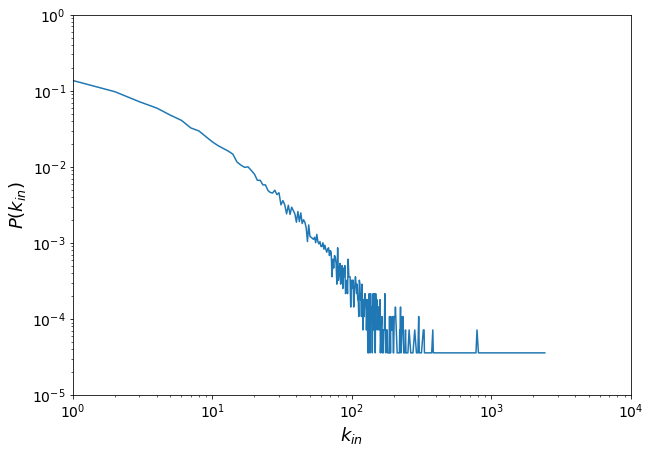

In [110]:
x = []
y = []

for i in sorted(degin_distri):
    x.append(i)
    y.append(degin_distri[i] / len(H))

plt.figure(figsize=(10, 7))
plt.plot(x, y)

plt.xlabel("$k_{in}$", fontsize=18)
plt.ylabel("$P(k_{in})$", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.xscale("log")
plt.axis([1, 10000, 0.00001, 1.0])

Let's plot the degree out distribution

In [117]:
outdeg = dict(H.out_degree()).values()
degout_distri = Counter(outdeg)

(1.0, 10000.0, 1e-05, 1.0)

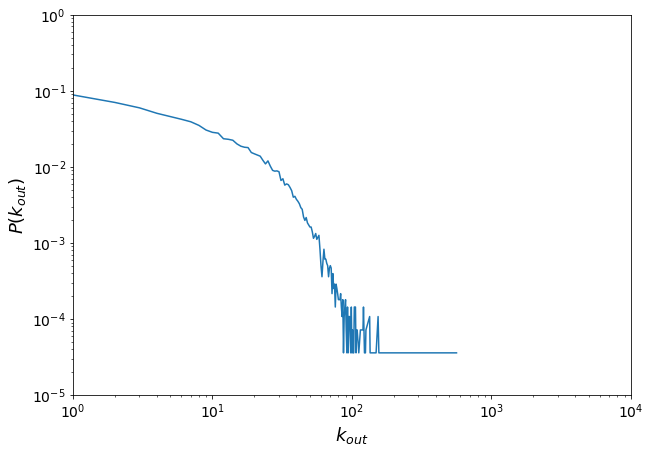

In [118]:
x = []
y = []
for i in sorted(degout_distri):
    x.append(i)
    y.append(float(degout_distri[i]) / len(H))

plt.figure(figsize=(10, 7))
plt.plot(np.array(x), np.array(y))

plt.xlabel("$k_{out}$", fontsize=18)
plt.ylabel("$P(k_{out})$", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.xscale("log")
plt.axis([1, 10000, 0.00001, 1.0])

## Generic import/export formats

NetworkX accepts a list of different import and export options for network data files.
More info is available here: https://networkx.org/documentation/stable/reference/readwrite/index.html

In [119]:
H = nx.read_edgelist("../datasets/cit-HepTh.txt", create_using=nx.DiGraph())

In [120]:
H.number_of_nodes()

27770

In the same way we can export to various formats, for example gml and gragml (be careful this is a large network!)

The file in gml/gexf format can be visualized using the software tool Gephi (http://gephi.org).

In [121]:
# nx.write_gml(H,'../network_data/citHepTh.gml')
# nx.write_graphml(H,'../network_data/citHepTh.graphml')

There are further options to import and export datasets that can be explored on the NetworkX docs.
For example for weighted edgelists one can easily do:

In [167]:
H = nx.read_weighted_edgelist("../datasets/USairport_2010.txt")
H.edges(data=True)

EdgeDataView([('29', '78', {'weight': 96.0}), ('29', '114', {'weight': 36918.0}), ('29', '117', {'weight': 47.0}), ('29', '134', {'weight': 20.0}), ('29', '169', {'weight': 40.0}), ('29', '206', {'weight': 33.0}), ('29', '296', {'weight': 95.0}), ('29', '300', {'weight': 22.0}), ('29', '311', {'weight': 1664.0}), ('29', '317', {'weight': 59847.0}), ('29', '381', {'weight': 22.0}), ('29', '391', {'weight': 27.0}), ('29', '403', {'weight': 15.0}), ('29', '432', {'weight': 152.0}), ('29', '435', {'weight': 45768.0}), ('29', '489', {'weight': 58.0}), ('29', '526', {'weight': 7710.0}), ('29', '534', {'weight': 10.0}), ('29', '609', {'weight': 2.0}), ('29', '610', {'weight': 25.0}), ('29', '619', {'weight': 153.0}), ('29', '691', {'weight': 27.0}), ('29', '709', {'weight': 29809.0}), ('29', '716', {'weight': 43.0}), ('29', '727', {'weight': 2.0}), ('29', '731', {'weight': 304.0}), ('29', '760', {'weight': 269.0}), ('29', '880', {'weight': 75.0}), ('29', '899', {'weight': 50.0}), ('29', '918'

In [178]:
import pandas as pd

df = pd.read_csv(
    "../datasets/USairport_2010.txt",
    delimiter=" ",
    header=None,
    names=["in", "out", "weight"],
)
df.head()

,in,out,weight
0,29,78,95
1,29,114,37483
2,29,117,47
3,29,134,16
4,29,169,40


In [182]:
H = nx.from_pandas_edgelist(df, source="in", target="out", edge_attr="weight")
H.edges(data=True)

EdgeDataView([(29, 78, {'weight': 96}), (29, 114, {'weight': 36918}), (29, 117, {'weight': 47}), (29, 134, {'weight': 20}), (29, 169, {'weight': 40}), (29, 206, {'weight': 33}), (29, 296, {'weight': 95}), (29, 300, {'weight': 22}), (29, 311, {'weight': 1664}), (29, 317, {'weight': 59847}), (29, 381, {'weight': 22}), (29, 391, {'weight': 27}), (29, 403, {'weight': 15}), (29, 432, {'weight': 152}), (29, 435, {'weight': 45768}), (29, 489, {'weight': 58}), (29, 526, {'weight': 7710}), (29, 534, {'weight': 10}), (29, 609, {'weight': 2}), (29, 610, {'weight': 25}), (29, 619, {'weight': 153}), (29, 691, {'weight': 27}), (29, 709, {'weight': 29809}), (29, 716, {'weight': 43}), (29, 727, {'weight': 2}), (29, 731, {'weight': 304}), (29, 760, {'weight': 269}), (29, 880, {'weight': 75}), (29, 899, {'weight': 50}), (29, 918, {'weight': 26}), (29, 978, {'weight': 46}), (29, 982, {'weight': 73017}), (29, 994, {'weight': 60}), (29, 1022, {'weight': 131}), (29, 1029, {'weight': 40}), (29, 1066, {'weigh

# Network Visualization 
## Visualizing a network with NetworkX

NetworkX combined with matplotlib can be used to visualize complex networks. 

It provides a good range of functionalities to obtain some basic and more refined visualization. More details are available in the [documentation](https://networkx.github.io/documentation/stable/reference/drawing.html).

Notice, as stated in the documentation
>NetworkX provides basic functionality for visualizing graphs, but its main goal is to enable graph analysis rather than perform graph visualization. 
>In the future, graph visualization functionality may be removed from NetworkX or only available as an add-on package.


We generate a random Erdos-Rényi network and visualize it.

In [122]:
N = 100
prob = 0.08

In [123]:
ER = nx.erdos_renyi_graph(N, prob)

(-1.174652632296001, 1.1280085066073422, -1.1978257341697718, 1.20884316931025)

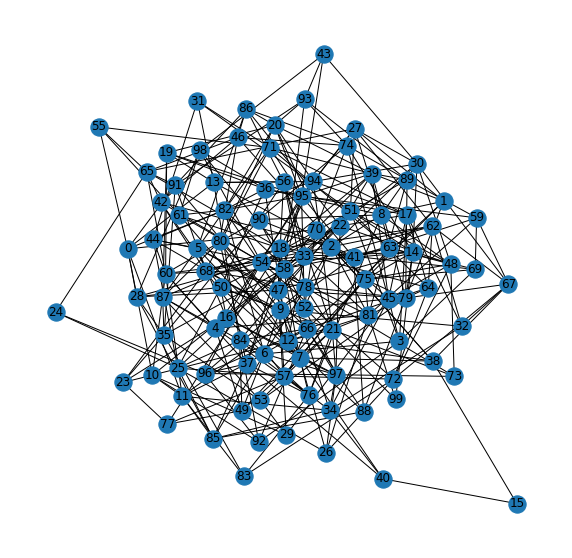

In [124]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(ER)
plt.axis("off")

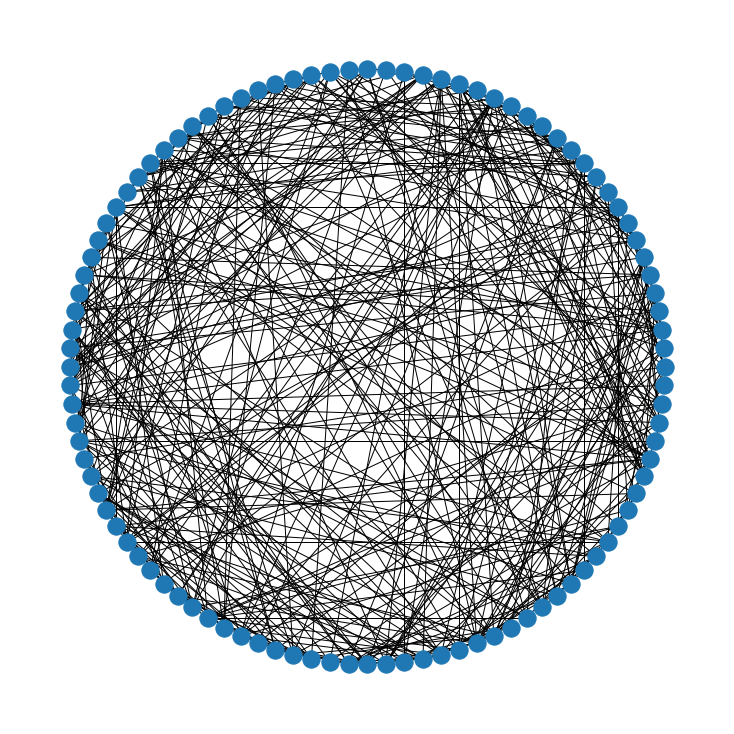

In [125]:
plt.figure(figsize=(10, 10))
nx.draw_circular(ER)

In [ ]:
plt.figure(figsize=(10, 10))
nx.draw_random(ER)

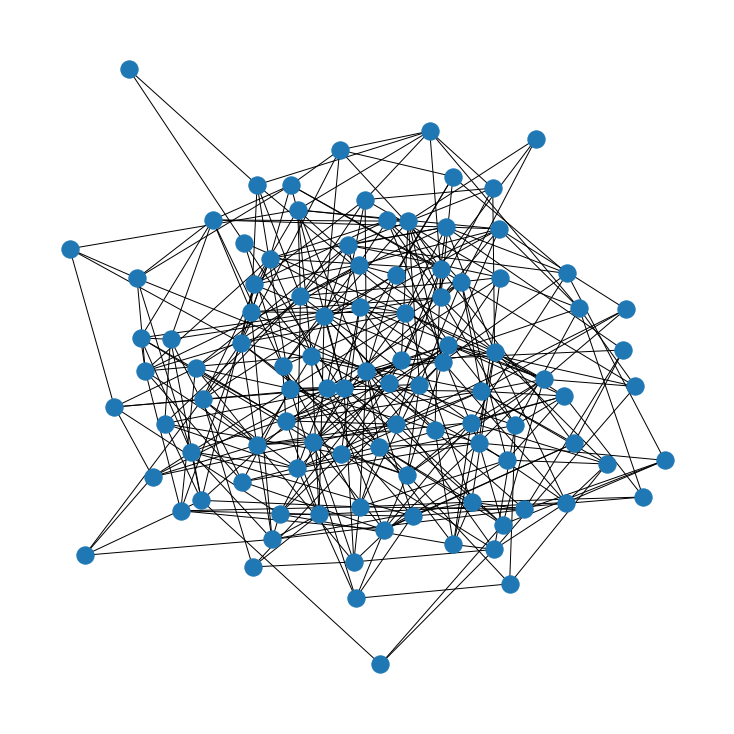

In [127]:
plt.figure(figsize=(10, 10))
nx.draw_spring(ER)

In [128]:
pos = nx.spring_layout(ER)
pos

{0: array([0.50383813, 0.0610905 ]),
 1: array([-0.42288591,  0.02205286]),
 2: array([0.0386422 , 0.06446744]),
 3: array([-0.53221565,  0.25452294]),
 4: array([-0.1855083 , -0.38908773]),
 5: array([ 0.31175967, -0.17351811]),
 6: array([-0.21053817, -0.19410634]),
 7: array([-0.08611293, -0.02533531]),
 8: array([-0.08518683,  0.11903908]),
 9: array([-0.15458059, -0.11336775]),
 10: array([-0.02414435,  0.35000669]),
 11: array([0.21723306, 0.38490167]),
 12: array([0.1425408 , 0.02172822]),
 13: array([ 0.27340927, -0.05946444]),
 14: array([0.06857048, 0.43439414]),
 15: array([0.37840422, 1.        ]),
 16: array([ 0.04575467, -0.2546965 ]),
 17: array([-0.13782247,  0.19458678]),
 18: array([-0.10029549, -0.26561239]),
 19: array([ 0.5628912, -0.1966566]),
 20: array([ 0.4678269 , -0.06224447]),
 21: array([-0.1709053 , -0.26400608]),
 22: array([ 0.08043195, -0.02643219]),
 23: array([-0.04938824, -0.57452467]),
 24: array([-0.22646925, -0.77885686]),
 25: array([-0.25514451,

We can draw the network nodes only, and assign a specific location to each node.

(-0.6885586002438214,
 0.7173139178790672,
 -0.8677997005759799,
 1.0889428428845704)

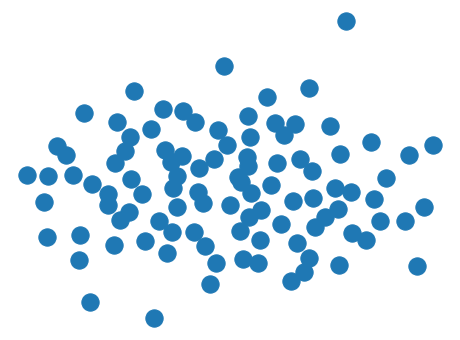

In [129]:
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(ER, pos)
plt.axis("off")

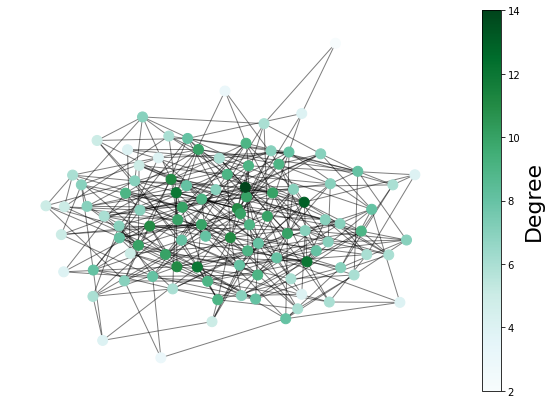

In [130]:
plt.figure(figsize=(10, 7))

s = nx.draw_networkx_nodes(
    ER,
    pos,
    node_size=100.0,
    node_color=list(dict(nx.degree(ER)).values()),
    alpha=1,
    cmap=plt.cm.BuGn,
)

nx.draw_networkx_edges(ER, pos, alpha=0.5)

# show the colorbar on the right side
cbar = plt.colorbar(s)
cbar.ax.set_ylabel("Degree", size=22)

plt.axis("off")
plt.show()

## Visualizing a spatial network with NetworkX

We analyze the US airport network of year 2010. 
The network is available from the [network repository of Tore Opshal](https://toreopsahl.com/datasets/#usairports).

Weights represent the total number of passengers who traveled on that connection in a year.

Airport coordinates have been added by myself.


In [131]:
airport_path = "../datasets/USairport_2010.txt"

In [132]:
meta_path = "../datasets/USairport_2010_codes.txt"

In [133]:
G = nx.Graph()
fh = open(airport_path, "r")
for line in fh.readlines():
    s = line.strip().split()
    G.add_edge(int(s[0]), int(s[1]))
fh.close()

In [134]:
len(G)

405

Is the network fully connected?

In [135]:
nx.number_connected_components(G)

2

The first connected component in the list is always the largest

In [136]:
c = list(nx.connected_components(G))
c[1]

{1182, 1347}

We define three dictionaries associated to the network to store additional node's features: IATA code, aiport name, geographic coordinates.

In [137]:
G.code = {}
G.name = {}
G.pos = {}

We extract nodes features from a file

In [138]:
finfo = open(meta_path, "r")
for line in finfo.readlines():
    s = line.strip().split()
    node = int(s[0])
    G.code[node] = s[1]
    G.name[node] = s[2]
    G.pos[node] = (float(s[4]), float(s[3]))
finfo.close()

Draw the network

(-127.04962499999999, -65.237875, 23.3436116, 50.0063884)

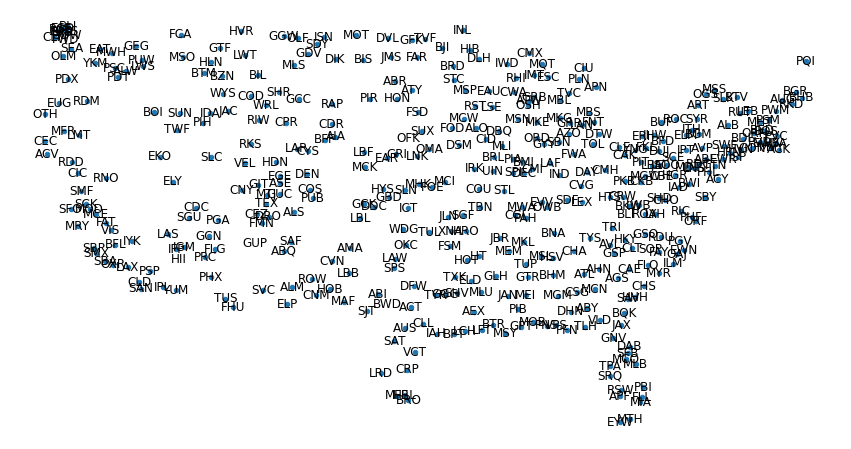

In [139]:
fig = plt.figure(figsize=(15, 8))

nx.draw_networkx_nodes(G, pos=G.pos, node_size=20)

# nx.draw_networkx_edges(G,pos=G.pos)

nx.draw_networkx_labels(G, pos=G.pos, labels=G.code)

plt.axis("off")

We would like to draw the edges but there are too many of them.

In [140]:
len(G.edges())

8251

We select only the strongest connections as a subgraph of G by setting a threshold on the annual passengers volume.

In [141]:
weight_threshold = 300000

In [142]:
H = nx.Graph()

H.pos = {}
H.code = {}
H.name = {}

fh = open(airport_path, "r")
for line in fh.readlines():
    s = line.strip().split()
    node1 = int(s[0])
    node2 = int(s[1])

    weight = int(s[2])

    if weight > weight_threshold:
        H.add_edge(node1, node2)

        H.pos[node1] = G.pos[node1]
        H.pos[node2] = G.pos[node2]

        H.code[node1] = G.code[node1]
        H.code[node2] = G.code[node2]

        H.name[node1] = G.name[node1]
        H.name[node2] = G.name[node2]

fh.close()

In [143]:
len(H.edges())

205

We draw the network and color code the nodes by their degree.

(-128.0307916725, -65.1911527775, 23.3436116, 50.0063884)

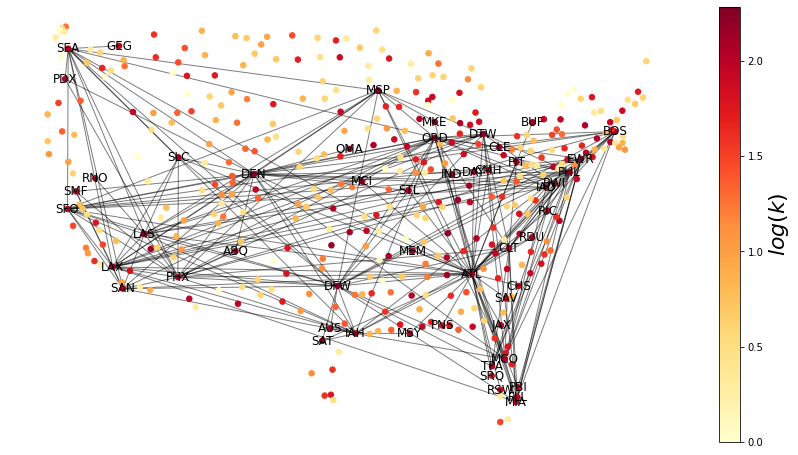

In [144]:
fig = plt.figure(figsize=(15, 8))

s = nx.draw_networkx_nodes(
    G,
    pos=G.pos,
    node_color=[math.log(G.degree(v), 10) for v in G],
    node_size=30,
    cmap=plt.cm.YlOrRd,
)

nx.draw_networkx_edges(H, pos=G.pos, alpha=0.5)

nx.draw_networkx_labels(
    H,
    pos=H.pos,
    labels=H.code,
)

cbar = plt.colorbar(s)
cbar.ax.set_ylabel("$log(k)$", size=22)

plt.axis("off")

What is the node with the largest degree?

In [145]:
max(dict(G.degree()).items(), key=itemgetter(1))

(389, 192)

In [146]:
G.name[389]

'Denver'

## Data visualization with NetworkX

The easy interface of NetworkX and matplotlib to draw georeferenced data can be used to visualize all type of data points with geo-coordinates. 

A nice example comes from the electoral results of the municipality of Turin available at [the Open Data repository AperTO](http://aperto.comune.torino.it/?q=taxonomy/term/111).

Electoral data can be geo-referenced through the [dataset containing every street number of the city with its coordinates](http://aperto.comune.torino.it/?q=node/504).

Based on this idea, we created a Web-interface to explore electoral data of the city of Torino: [Il colore di Torino](http://datainterfaces.org/projects/ilcoloreditorino/)